<a href="https://colab.research.google.com/github/galib-abdun-noor/Bengali-Offensive-Language-BERT/blob/main/Offensive_Language_Detection_on_TB_OLID_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tweet-preprocessor

In [ ]:
import sklearn
import numpy as np
import pandas as pd
import re
import preprocessor as p
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

In [ ]:
# Load and combine train and test datasets
train = pd.read_json("train.json")
test = pd.read_json("test.json")
data = pd.concat([train, test], ignore_index=True)

In [ ]:
# Display the first few rows of the dataset
data.head()

,text,code_mixed_gold,offensive_gold,target_gold
0,eta ki kuno date??,C,N,None
1,@Mehedi Hasan . Notun SIM e prothom 54 taka ...,C,N,None
2,@Sayed Islam . Amader ei offer ti maximum 5 ...,C,N,None
3,@Sumon . amader shathe shorashori kotha bola...,C,N,None
4,#Ajk Jdoi kono Hindo . Vuddo . Gristan ar upo...,T,N,None


In [ ]:
# total number of offensive_gold types N and O separately
offensive_counts = data['offensive_gold'].value_counts()

In [ ]:
# Check for missing values
print("\nMissing Values:")
data.isnull().sum()


Missing Values:


,0
text,0
code_mixed_gold,0
offensive_gold,0
target_gold,2618


In [ ]:
# Data Cleaning
# Define regex patterns for cleaning text
REPLACE_NO_SPACE = re.compile(r"(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\|)|(\()|(\))|(\[)|(\])|(\%)|(\$)|(\>)|(\<)|(\{)|(\})")
REPLACE_WITH_SPACE = re.compile(r"(<br\s/><br\s/?)|(-)|(/)|(:)")

In [ ]:
def clean_tweets(df):
    tempArr = []
    for line in df:
        tmpL = p.clean(line)  # Clean using tweet preprocessor
        tmpL = REPLACE_NO_SPACE.sub("", tmpL.lower())  # Remove punctuation and convert to lowercase
        tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)  # Replace specific characters with space
        tempArr.append(tmpL)
    return tempArr

In [ ]:
# Apply cleaning to the combined dataset
data["clean_text"] = clean_tweets(data["text"])

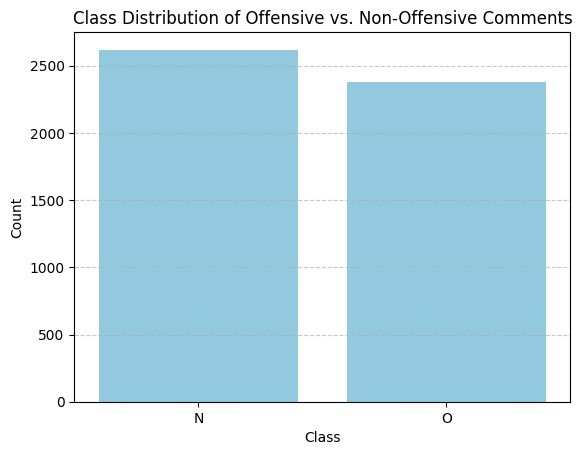

In [ ]:
# Visualize class distribution
sns.countplot(x="offensive_gold", data=data, color='skyblue')
plt.title("Class Distribution of Offensive vs. Non-Offensive Comments")
plt.xlabel("Class")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Extract labels and cleaned text
y = data.offensive_gold.values
X = data.clean_text.values

In [ ]:
# Create a DataFrame
dataset = pd.DataFrame({'Clean Text': X, 'Terget': y})

# Display the dataset
dataset

,Clean Text,Terget
0,eta ki kuno date,N
1,hasan notun sim e prothom taka recharge kore ...,N
2,islam amader ei offer ti maximum bar neya jabe,N
3,amader shathe shorashori kotha bolar jonno di...,N
4,jdoi kono hindo vuddo gristan ar upor amn ni...,N
...,...,...
4995,tokhon amr selfi dorkar nai,N
4996,tor baba koto jon cilo,O
4997,tor ma ki bal nam rakse,O
4998,vai re aj oder rojinga upor hoscehoyto goto te...,N


In [ ]:
# Convert labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1, test_size=0.2, shuffle=True)

In [ ]:
# Feature Extraction
# Bag-of-Words (BoW) representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Implementing Traditional ML Models
# Most Frequent Class Baseline
most_frequent_class = Counter(y_train).most_common(1)[0][0]
y_pred_baseline = [most_frequent_class] * len(y_test)

print("\nMost Frequent Class Baseline Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline, pos_label=most_frequent_class):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_baseline, pos_label=most_frequent_class):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_baseline, pos_label=most_frequent_class):.4f}")


Most Frequent Class Baseline Performance:
Accuracy: 0.5240
Precision: 0.5240
Recall: 1.0000
F1 Score: 0.6877



Naive Bayes Performance:
Accuracy: 0.7380
Precision: 0.7388
Recall: 0.6954
F1 Score: 0.7165


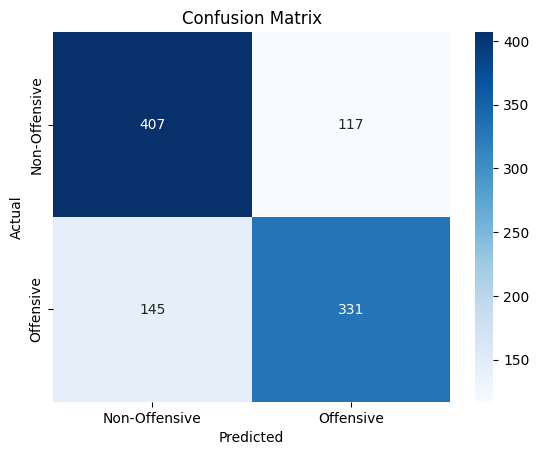

In [ ]:
# Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train_bow, y_train)
y_pred_nb = nb_model.predict(X_test_bow)

print("\nNaive Bayes Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_nb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_nb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_nb):.4f}")

cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Offensive', 'Offensive'], yticklabels=['Non-Offensive', 'Offensive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Logistic Regression Performance:
Accuracy: 0.7360
Precision: 0.7611
Recall: 0.6492
F1 Score: 0.7007


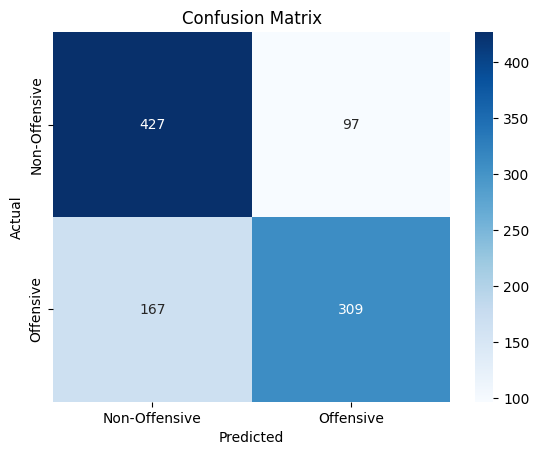

In [ ]:
# Logistic Regression Model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Offensive', 'Offensive'], yticklabels=['Non-Offensive', 'Offensive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Support Vector Machine (SVM) Model
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("\nSupport Vector Machine Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm):.4f}")

cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Offensive', 'Offensive'], yticklabels=['Non-Offensive', 'Offensive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

NameError: name 'SVC' is not defined


Random Forest Performance:
Accuracy: 0.7380
Precision: 0.8302
Recall: 0.5651
F1 Score: 0.6725


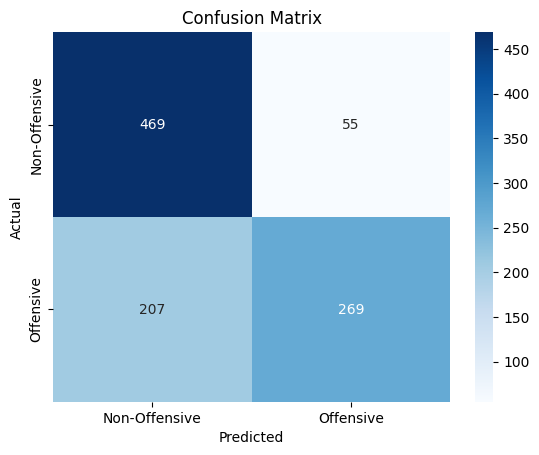

In [ ]:
# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1)
rf_model.fit(X_train_bow, y_train)
y_pred_rf = rf_model.predict(X_test_bow)

print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Offensive', 'Offensive'], yticklabels=['Non-Offensive', 'Offensive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

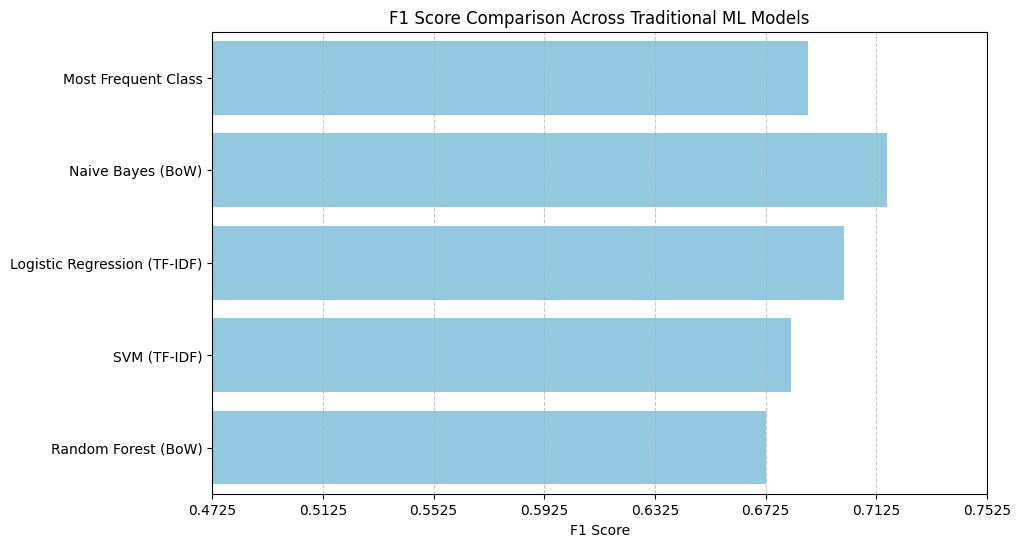

In [ ]:
# Visualize Traditional ML Model Performance
models = ["Most Frequent Class", "Naive Bayes (BoW)", "Logistic Regression (TF-IDF)", "SVM (TF-IDF)", "Random Forest (BoW)"]
f1_scores = [
    f1_score(y_test, y_pred_baseline, pos_label=most_frequent_class),
    f1_score(y_test, y_pred_nb),
    f1_score(y_test, y_pred_lr),
    f1_score(y_test, y_pred_svm),
    f1_score(y_test, y_pred_rf)
]

plt.figure(figsize=(10, 6))
sns.barplot(y=models, x=f1_scores, color='skyblue')
plt.title("F1 Score Comparison Across Traditional ML Models")
plt.xlabel("F1 Score")
plt.xlim(min(f1_scores) - 0.01, max(f1_scores) + 0.03)  # Reducing the front space
plt.xticks(np.arange(min(f1_scores) - 0.2, max(f1_scores) + 0.05, step=0.04))
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Implementing Pre-trained Transformer-Based Models
# Define dataset class for Transformers
class BanglaDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# Load and fine-tune pre-trained models
pretrained_models = ["csebuetnlp/banglabert","csebuetnlp/banglishbert","google-bert/bert-base-multilingual-cased","FacebookAI/xlm-roberta-base","GroNLP/hateBERT","diptanu/fBERT","neuropark/sahajBERT"]

In [ ]:
# Dictionary to store evaluation scores
accuracy_scores = {}
precision_scores = {}
recall_scores = {}
f1_scores = {}

for model_name in pretrained_models:
    print(f"\nFine-Tuning {model_name}:")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Tokenize the text data
    train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
    test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

    # Create datasets
    train_dataset = BanglaDataset(train_encodings, list(y_train))
    test_dataset = BanglaDataset(test_encodings, list(y_test))

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
    )
 # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate()
    print(eval_result)
     # Compute evaluation metrics
    predictions = trainer.predict(test_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_scores[model_name] = f1
    accuracy_scores[model_name] = accuracy
    precision_scores[model_name] = precision
    recall_scores[model_name] = recall

    print(f"\nEvaluation Metrics for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


Fine-Tuning csebuetnlp/banglabert:


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,No log,0.478894
2,0.509800,0.470342
3,0.509800,0.514734


{'eval_loss': 0.5147340893745422, 'eval_runtime': 6.98, 'eval_samples_per_second': 143.266, 'eval_steps_per_second': 9.026, 'epoch': 3.0}

Evaluation Metrics for csebuetnlp/banglabert:
Accuracy: 0.7680
Precision: 0.7293
Recall: 0.8151
F1 Score: 0.7698

Fine-Tuning csebuetnlp/banglishbert:


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/874 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/366k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglishbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.521160
2,0.525800,0.542390
3,0.525800,0.644466


{'eval_loss': 0.6444659233093262, 'eval_runtime': 7.3589, 'eval_samples_per_second': 135.89, 'eval_steps_per_second': 8.561, 'epoch': 3.0}

Evaluation Metrics for csebuetnlp/banglishbert:
Accuracy: 0.7520
Precision: 0.7500
Recall: 0.7185
F1 Score: 0.7339

Fine-Tuning google-bert/bert-base-multilingual-cased:


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.584250
2,0.578000,0.505196
3,0.578000,0.532638


{'eval_loss': 0.5326380729675293, 'eval_runtime': 6.937, 'eval_samples_per_second': 144.154, 'eval_steps_per_second': 9.082, 'epoch': 3.0}

Evaluation Metrics for google-bert/bert-base-multilingual-cased:
Accuracy: 0.7440
Precision: 0.7209
Recall: 0.7542
F1 Score: 0.7372

Fine-Tuning FacebookAI/xlm-roberta-base:


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.661630
2,0.662900,0.600667
3,0.662900,0.582235


{'eval_loss': 0.5822348594665527, 'eval_runtime': 6.2594, 'eval_samples_per_second': 159.759, 'eval_steps_per_second': 10.065, 'epoch': 3.0}

Evaluation Metrics for FacebookAI/xlm-roberta-base:
Accuracy: 0.7180
Precision: 0.7256
Recall: 0.6555
F1 Score: 0.6887

Fine-Tuning GroNLP/hateBERT:


tokenizer_config.json:   0%|          | 0.00/151 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.563791
2,0.571200,0.562205
3,0.571200,0.566365


{'eval_loss': 0.5663648247718811, 'eval_runtime': 6.8956, 'eval_samples_per_second': 145.021, 'eval_steps_per_second': 9.136, 'epoch': 3.0}

Evaluation Metrics for GroNLP/hateBERT:
Accuracy: 0.7460
Precision: 0.7293
Recall: 0.7416
F1 Score: 0.7354

Fine-Tuning diptanu/fBERT:


tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at diptanu/fBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.573039
2,0.576100,0.566867
3,0.576100,0.586578


{'eval_loss': 0.5865776538848877, 'eval_runtime': 6.8729, 'eval_samples_per_second': 145.499, 'eval_steps_per_second': 9.166, 'epoch': 3.0}

Evaluation Metrics for diptanu/fBERT:
Accuracy: 0.7160
Precision: 0.6920
Recall: 0.7269
F1 Score: 0.7090

Fine-Tuning neuropark/sahajBERT:


tokenizer_config.json:   0%|          | 0.00/471 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/813 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/322 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/72.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at neuropark/sahajBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.652152
2,0.648800,0.609309
3,0.648800,0.617767


{'eval_loss': 0.6177669763565063, 'eval_runtime': 25.5832, 'eval_samples_per_second': 39.088, 'eval_steps_per_second': 2.463, 'epoch': 3.0}

Evaluation Metrics for neuropark/sahajBERT:
Accuracy: 0.6890
Precision: 0.6923
Recall: 0.6239
F1 Score: 0.6564


In [ ]:
# Create a DataFrame with all metrics using `pretrained_models` for Model names
metrics_df = pd.DataFrame({
    "Model": pretrained_models,
    "F1 Score": f1_scores.values(),
    "Accuracy": accuracy_scores.values(),
    "Precision": precision_scores.values(),
    "Recall": recall_scores.values()
})

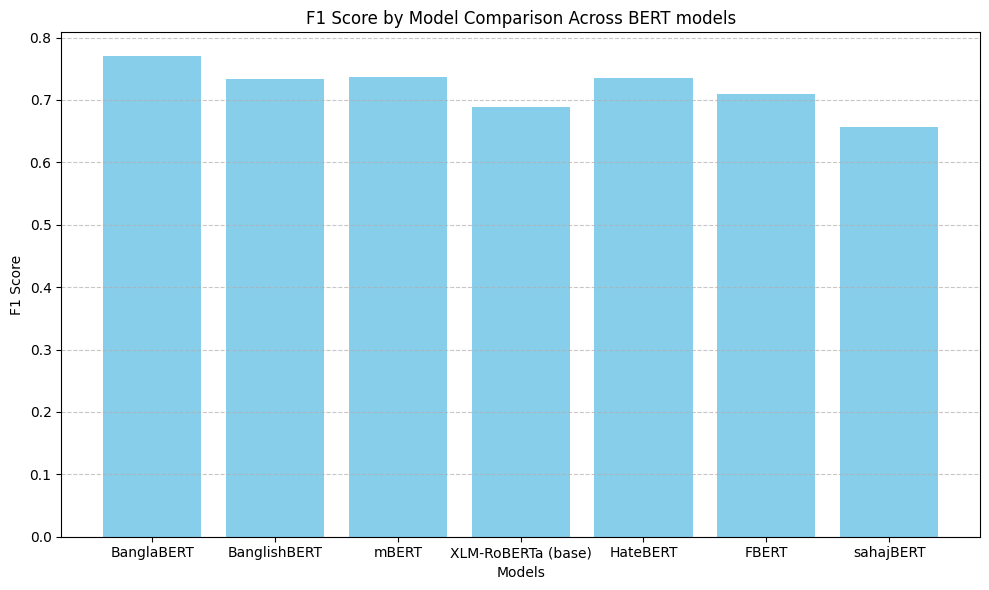

In [ ]:
# Plotting Vertical Bar Chart for F1 Score only
plt_models = ["BanglaBERT","BanglishBERT","mBERT","XLM-RoBERTa (base)","HateBERT","FBERT","sahajBERT"]
plt.figure(figsize=(10, 6))
plt.bar(plt_models, metrics_df["F1 Score"], color='skyblue')
plt.title("F1 Score by Model Comparison Across BERT models")
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()